In [1]:
# Amazon Review Analysis Pipeline using NLP and Spark
# Ravi Patel 12291812
# Lyric Randle 16253122
# Michelle Lu 16127324
# Mason Allaman 16365811

# Abstract:
# Text data around product reviews is abundant with the growth of Amazon. Gathering actionable information from these reviews 
# can be key to adjust product decisions. This can include specific phrases that can be associated with negative and positive 
# reviews to training a classifier specifically around sentiment in the context of an industry or product segment. The value 
# generated is vast, but there can be difficulties to processing the amount of data. This experiment is going to be around processing 
# the 2013 Amazing reviews dataset using Spark and SparkNLP within a Docker Compose environment. 

In [2]:
import mysql.connector
import pandas as pd
import seaborn as sns
import json

con = mysql.connector.connect(
    user="root", password="root", host="mysql-server", database="product_analysis"
)

curs = con.cursor(dictionary=True)

In [3]:
# Ensure database tables have been created
curs.execute("show tables")
curs.fetchall()

[{'Tables_in_product_analysis': 'agg_product_review'},
 {'Tables_in_product_analysis': 'processed_review'},
 {'Tables_in_product_analysis': 'products'},
 {'Tables_in_product_analysis': 'reviews'}]

In [4]:
# Total Reviews ingested:
curs.execute("select count(*) as total_reviews from reviews")
curs.fetchall()[0]['total_reviews']

10391734

In [5]:
# Total Products ingested:
curs.execute("select count(*) as total_products from products")
curs.fetchall()[0]['total_products']

657933

In [6]:
# Sample of processed reviews:
curs.execute("select * from processed_review inner join reviews on processed_review.review_id = reviews.id limit 5")
curs.fetchall()

[{'id': 593640,
  'review_id': '593640',
  'metric_type': 'key_phrases',
  'metric': b'{"phrases": [{"phrase": "power tool", "score": 0.5618283033779027, "sentence": "0"}]}',
  'product_id': '0310230691',
  'helpfulness': 1.0,
  'rating': 4.0,
  'summary': "Power Tool I had no problem figuring out the software interface. The commentaries and parallel translations are great. I have used the study guide to develop sermon outlines. It would take a stack of books 6 feet tall to equal the resources available. The NIV is not public domain like so many older translations so you don't find as many programs available. Kudos to Zondervan for developing such a good NIV resource.",
  'processed': 1},
 {'id': 593641,
  'review_id': '593641',
  'metric_type': 'key_phrases',
  'metric': b'{"phrases": []}',
  'product_id': '0310230691',
  'helpfulness': 0.846154,
  'rating': 5.0,
  'summary': "Just what I was looking for I was trying to find a Bible software that would help me with my daily Bible stud

In [7]:
# Sample of processed reviews that aren't books:
curs.execute("select p.title, p.category from products p  inner join reviews r on p.id = r.product_id where p.category != 'Books' limit 10")
curs.fetchall()

[{'title': 'Pope John Paul II: The Movie [VHS]', 'category': 'Movies_&_TV'},
 {'title': 'Pope John Paul II: The Movie [VHS]', 'category': 'Movies_&_TV'},
 {'title': 'Pope John Paul II: The Movie [VHS]', 'category': 'Movies_&_TV'},
 {'title': 'Pope John Paul II: The Movie [VHS]', 'category': 'Movies_&_TV'},
 {'title': 'Pope John Paul II: The Movie [VHS]', 'category': 'Movies_&_TV'},
 {'title': 'Pope John Paul II: The Movie [VHS]', 'category': 'Movies_&_TV'},
 {'title': "A NATION ADRIFT A Chronicle of America's Providential Heritage [VHS]",
  'category': 'Movies_&_TV'},
 {'title': "A NATION ADRIFT A Chronicle of America's Providential Heritage [VHS]",
  'category': 'Movies_&_TV'},
 {'title': "A NATION ADRIFT A Chronicle of America's Providential Heritage [VHS]",
  'category': 'Movies_&_TV'},
 {'title': "The Stableboy's Christmas [VHS]", 'category': 'Movies_&_TV'}]

,title,num_reviews
0,"Kindle Wireless Reading Device, Free 3G, 6"" Di...",21452
1,Kindle: Amazon's Original Wireless Reading Dev...,15858
2,The Giver,7644
3,Measure Of A Man,6910
4,Plantronics Voyager 510 Bluetooth Headset [Ret...,6886


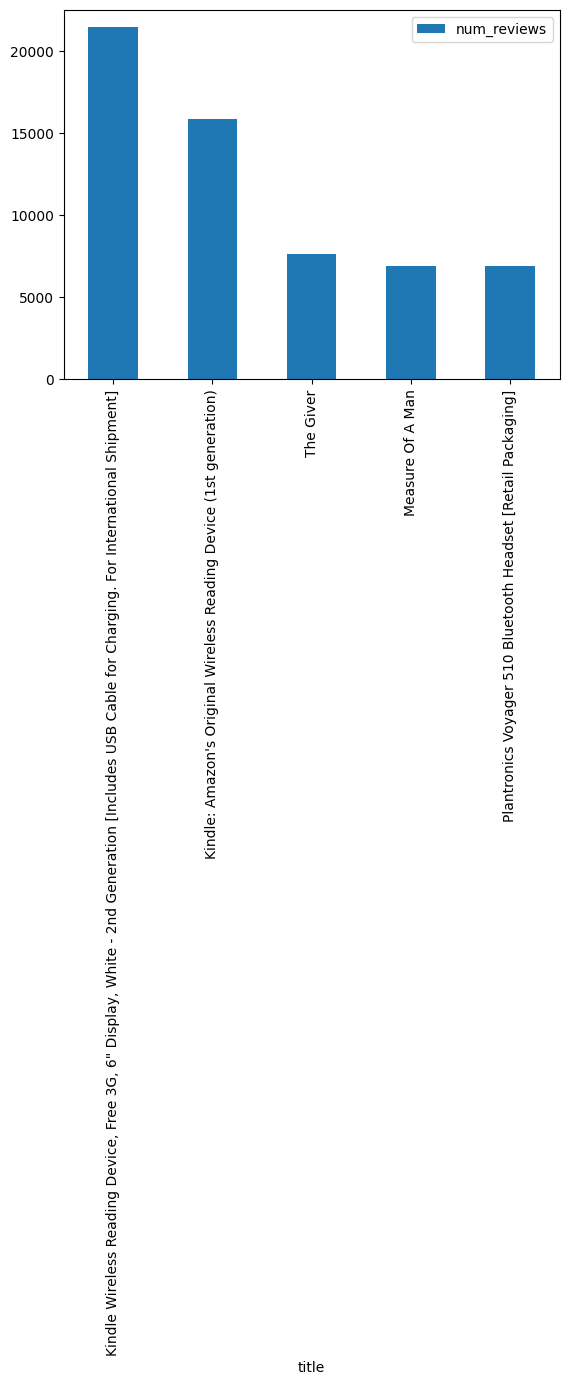

In [8]:
# Get products with the largest amount of ratings:
curs.execute("""SELECT products.title, COUNT(reviews.id) AS num_reviews
FROM products
LEFT JOIN reviews ON products.id = reviews.product_id
GROUP BY products.id order by num_reviews desc limit 5""")
top_reviewed_products = pd.DataFrame(curs.fetchall())
top_reviewed_products.plot(kind='bar',x='title')
top_reviewed_products

In [9]:
# Get review counts per product category
curs.execute("""SELECT products.category, COUNT(id) AS category_counts
FROM products
GROUP BY products.category""")
category_counts = curs.fetchall()


<Axes: xlabel='category'>

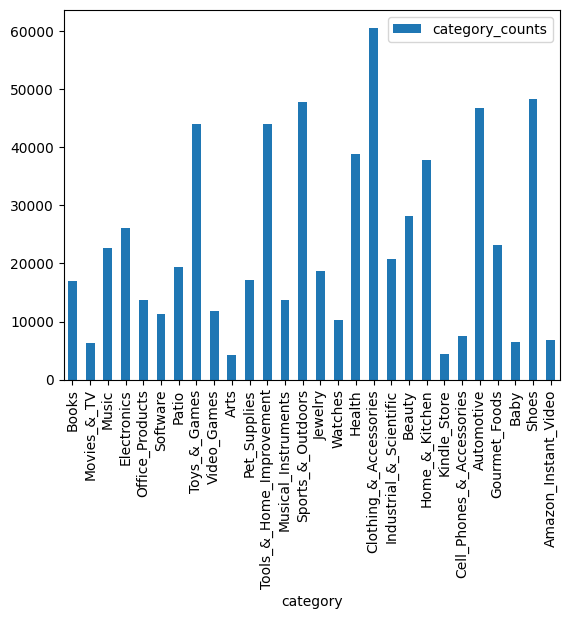

In [10]:
# Plot the counts per category
cat_df = pd.DataFrame(category_counts)
cat_df
cat_df.plot(kind='bar',x='category')

In [11]:
# Follow how many reviews have been processed so far for key phrases
curs.execute('select count(*) from reviews where processed = 1')
curs.fetchall()

[{'count(*)': 12157}]

In [12]:
# Follow how many products have been processed so far for topics
curs.execute('select count(*) from agg_product_review')
curs.fetchall()

[{'count(*)': 2568}]

/opt/conda/lib/python3.11/site-packages/pandas/plotting/_matplotlib/tools.py:233: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


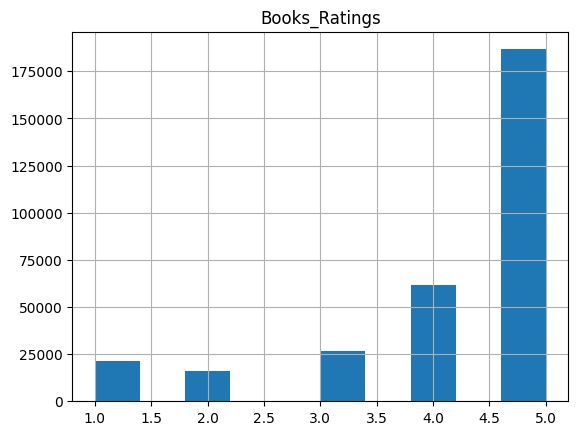

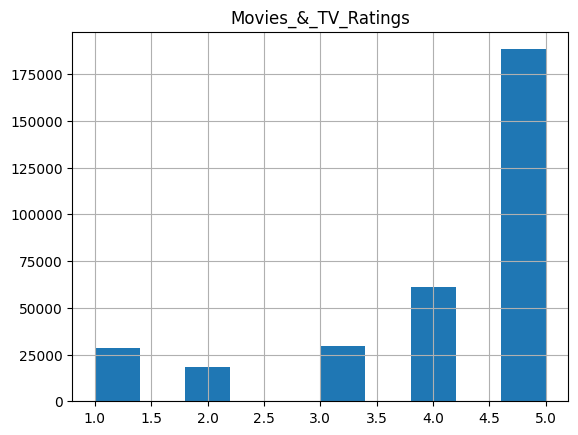

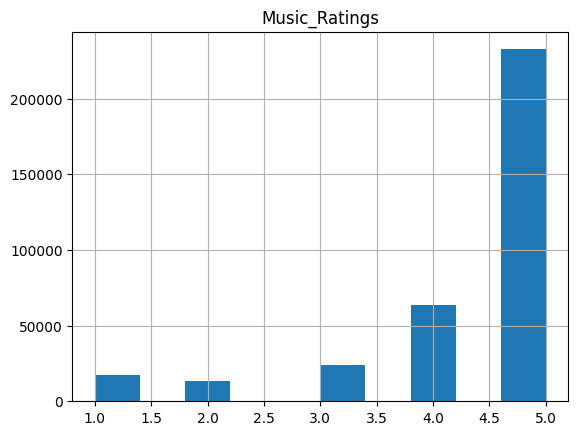

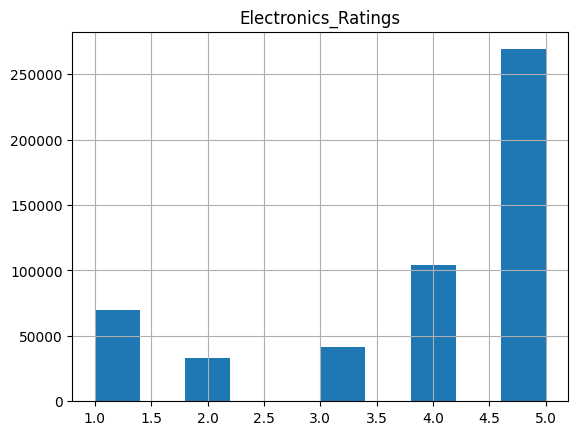

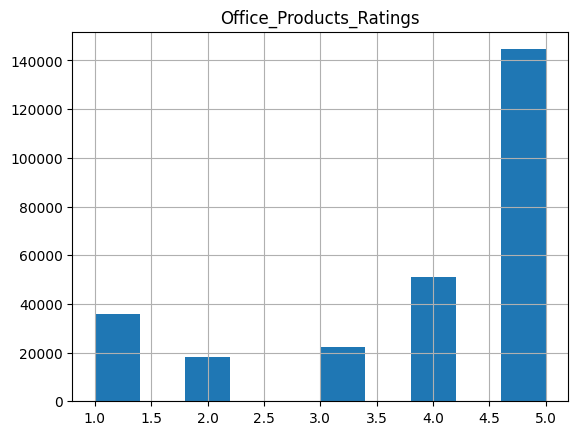

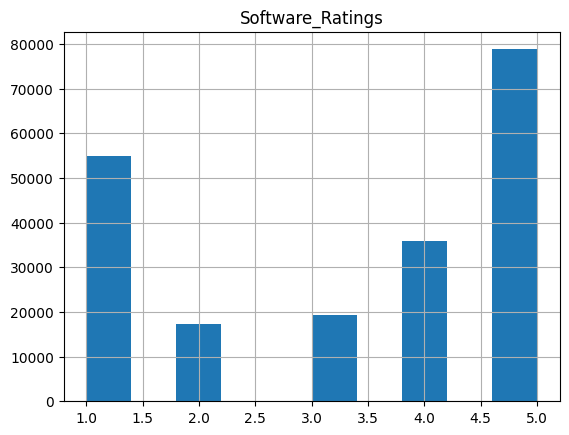

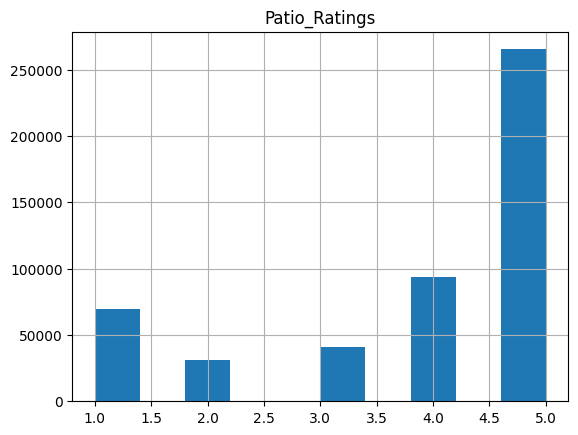

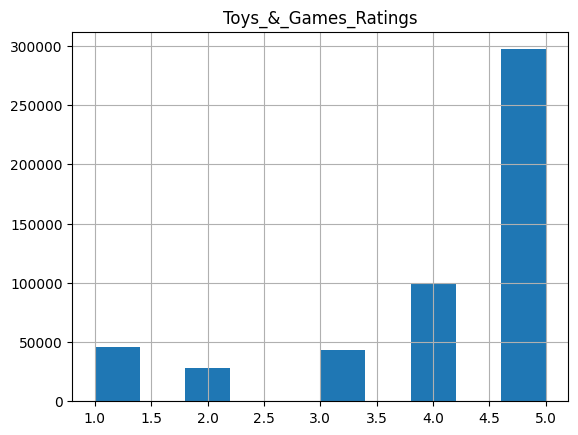

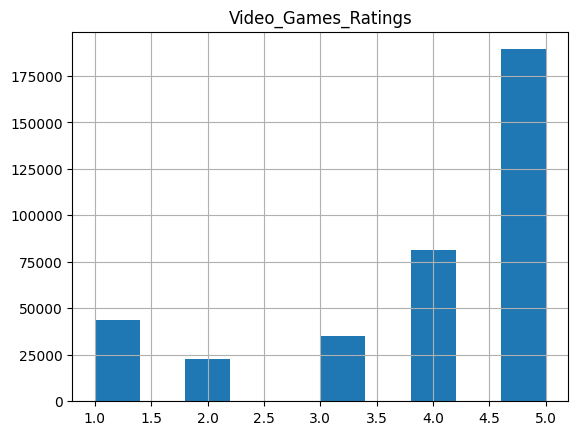

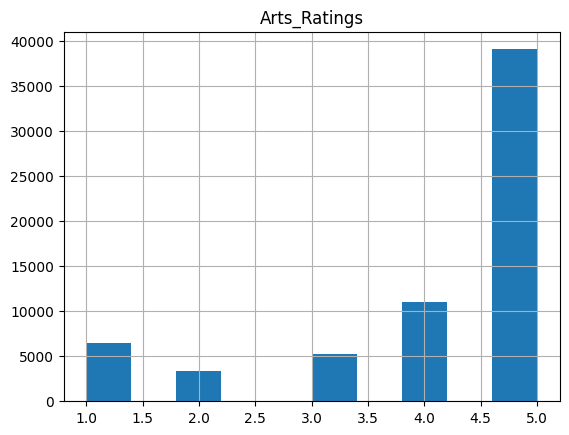

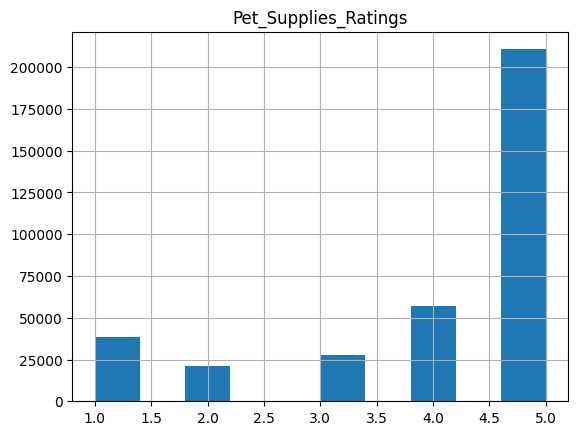

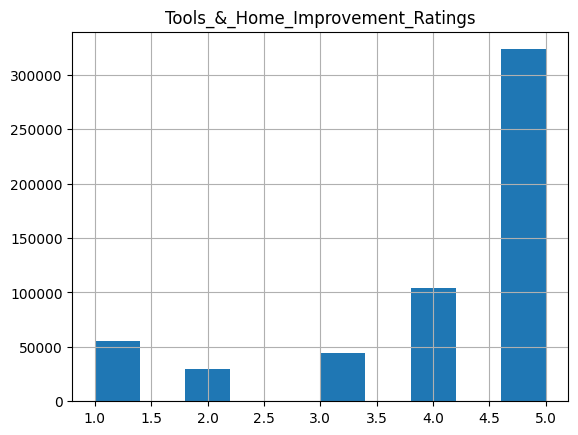

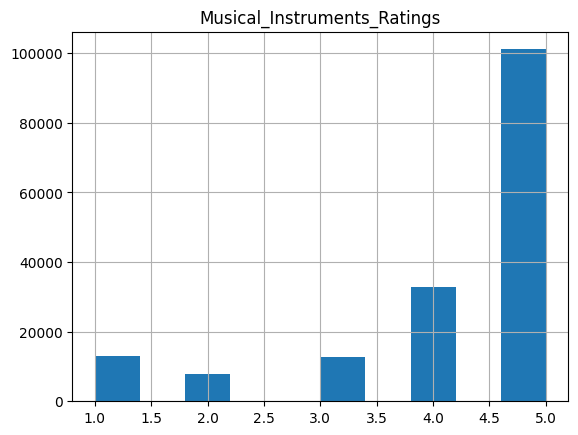

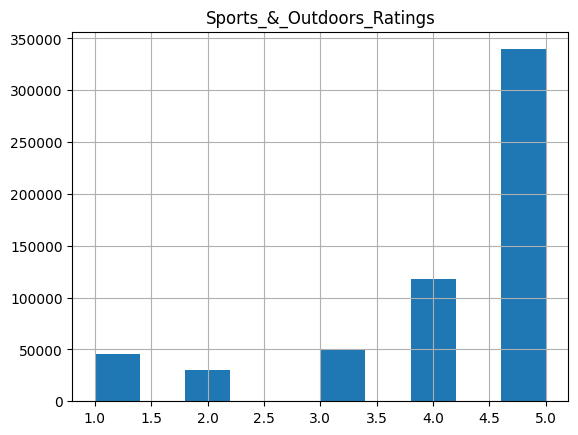

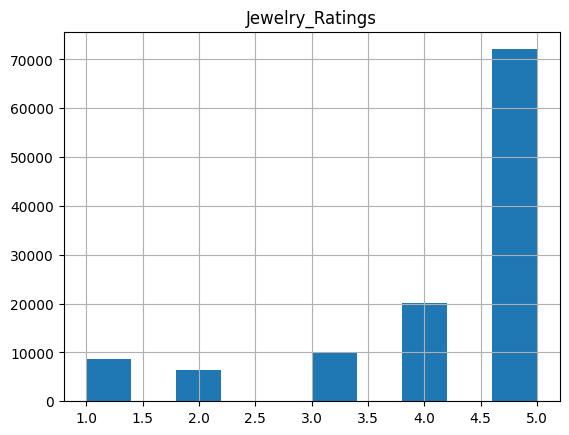

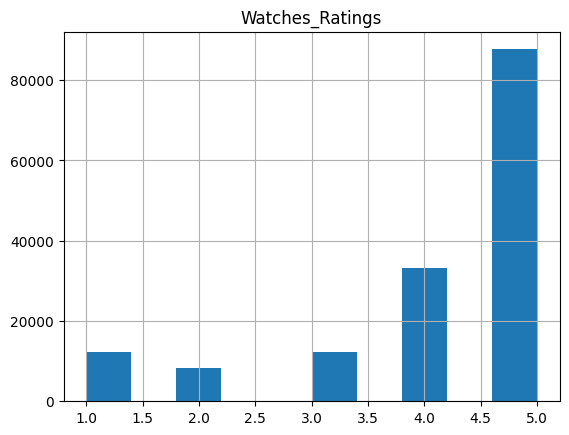

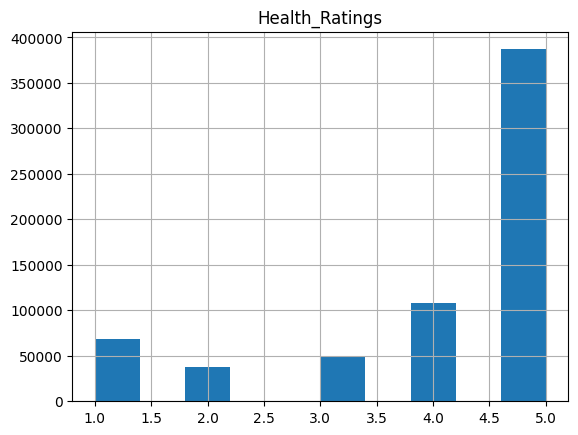

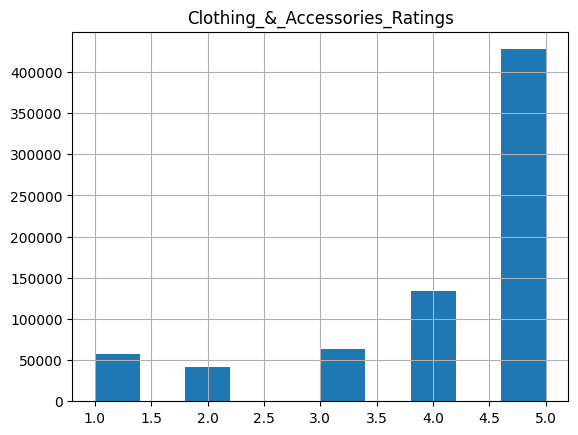

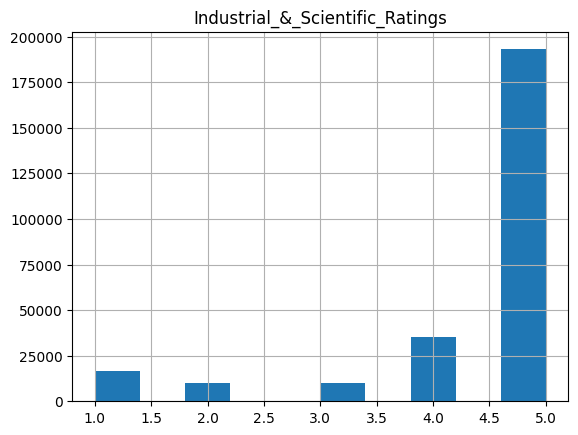

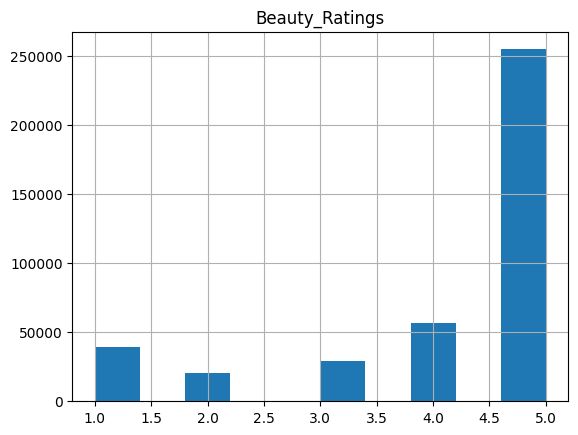

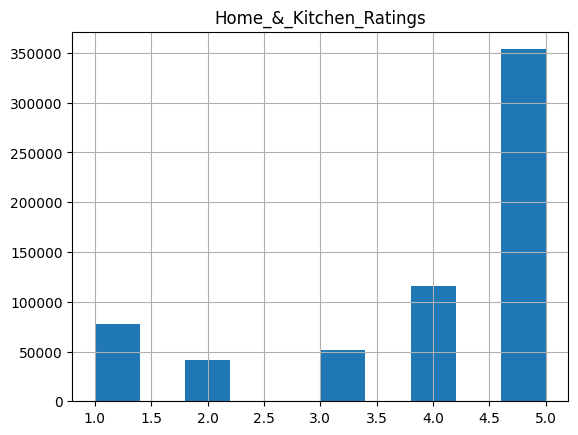

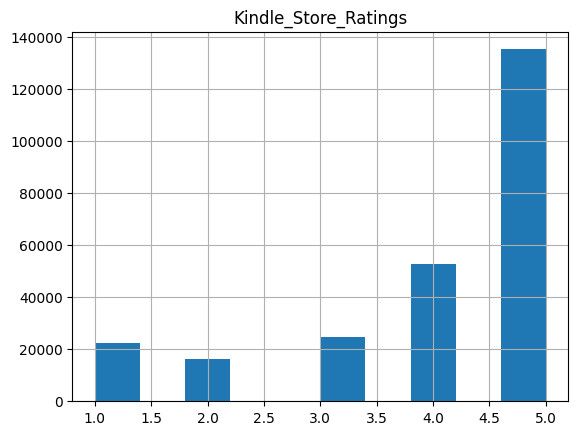

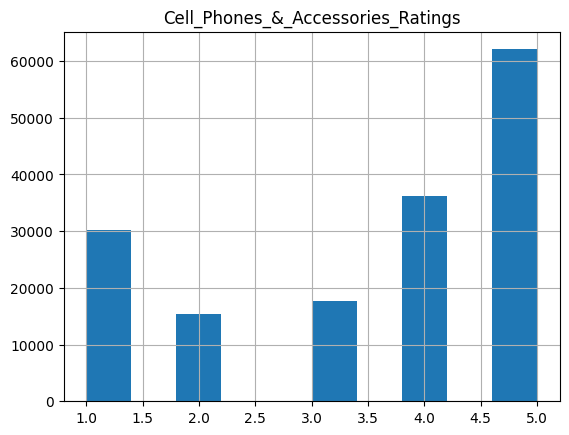

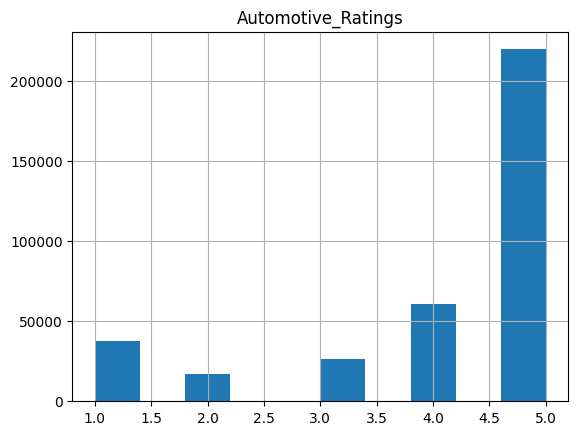

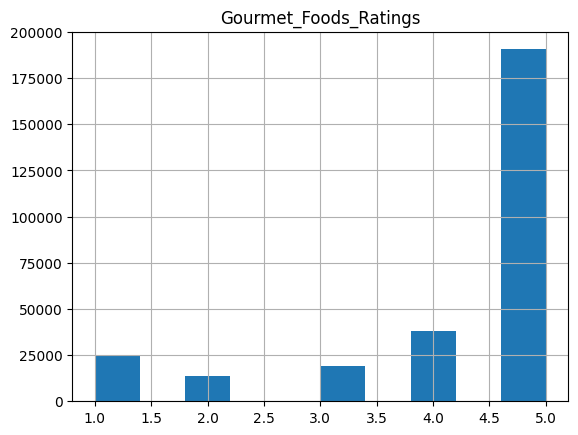

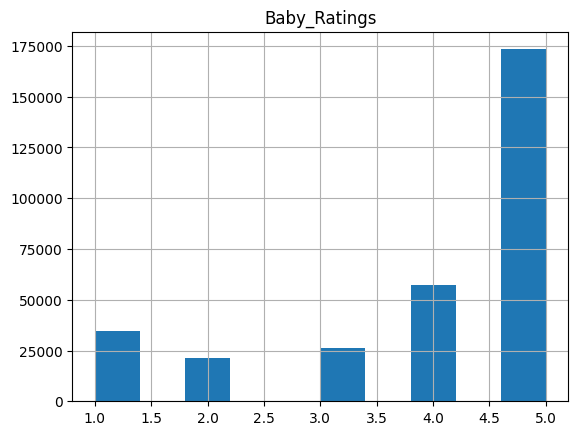

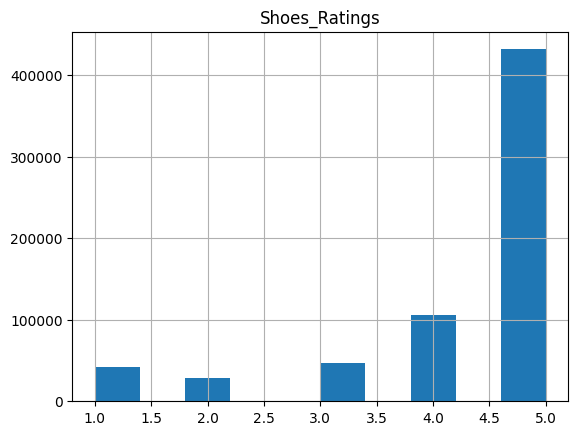

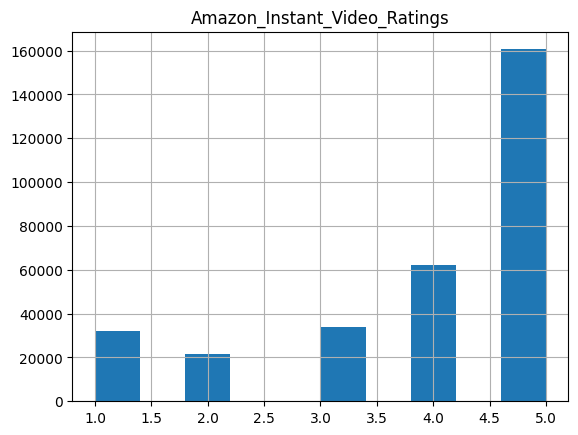

In [13]:
# Get histograms for ratings by category
for category in category_counts:
    curs.execute('select rating from reviews inner join products on products.id = reviews.product_id where products.category=%s',[category['category']])
    cat_ratings = curs.fetchall()            
    cat_rating_df = pd.DataFrame(cat_ratings)
    cat_rating_df.columns = [f'{category["category"]}_Ratings']
    cat_rating_df.hist()

/opt/conda/lib/python3.11/site-packages/pandas/plotting/_matplotlib/tools.py:233: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


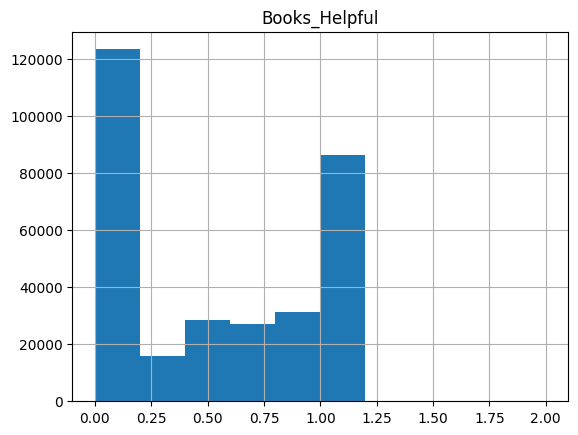

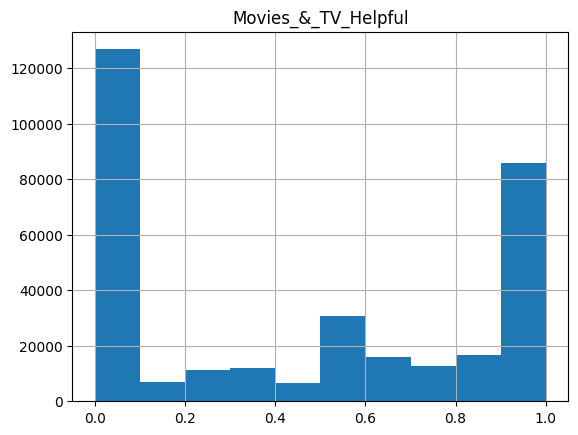

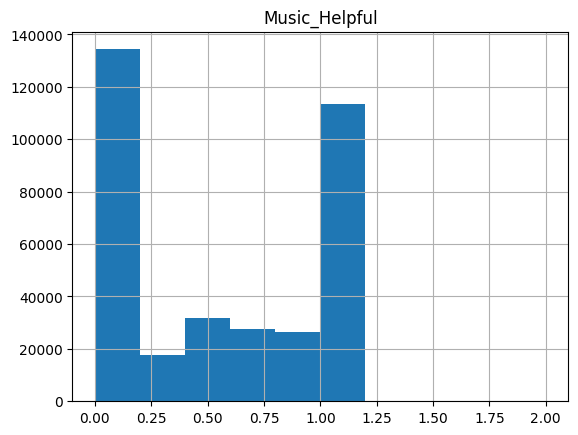

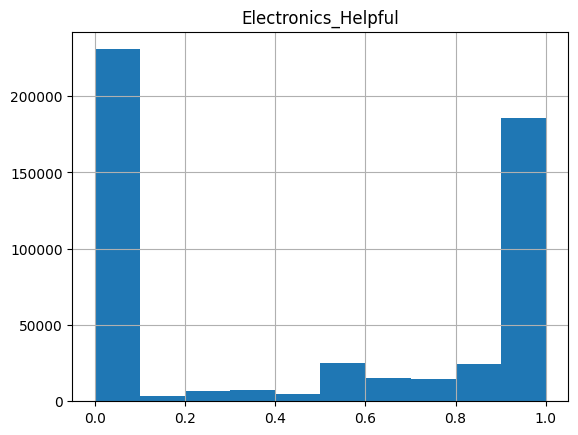

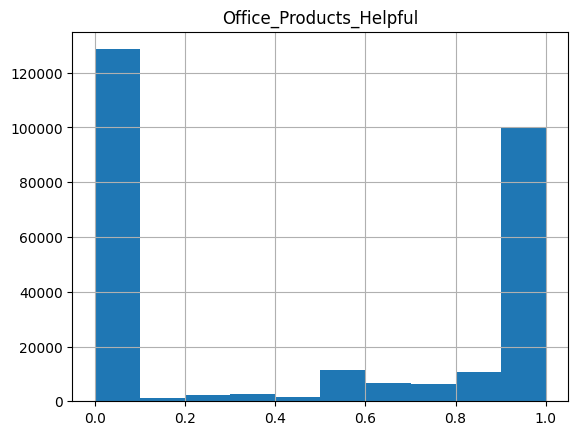

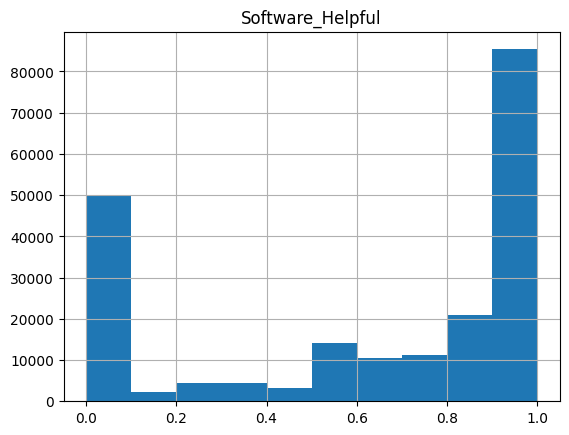

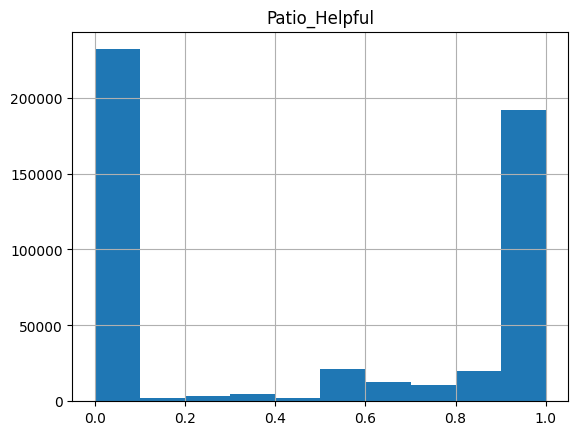

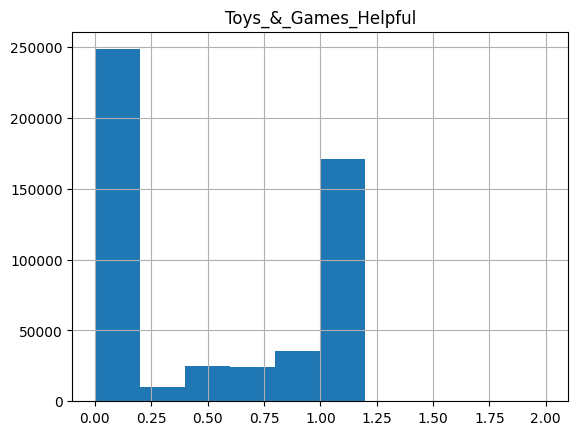

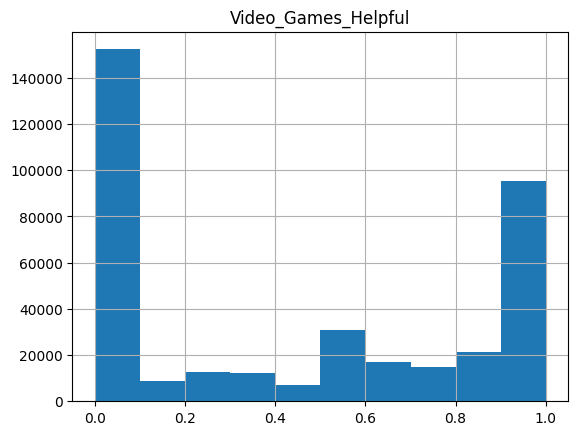

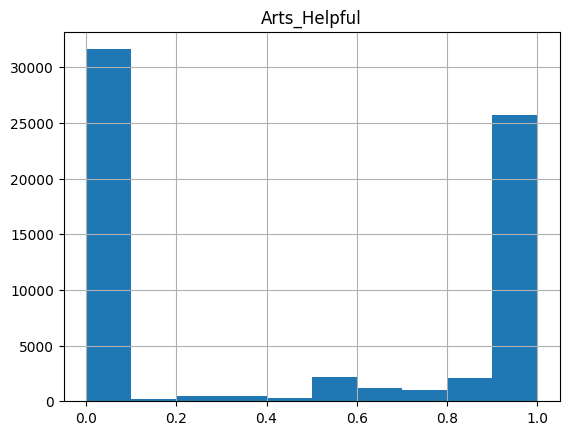

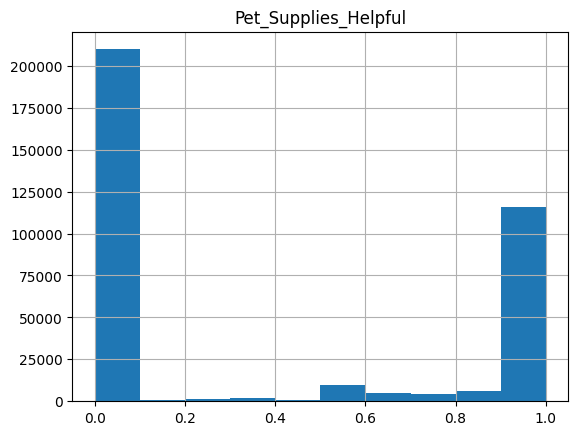

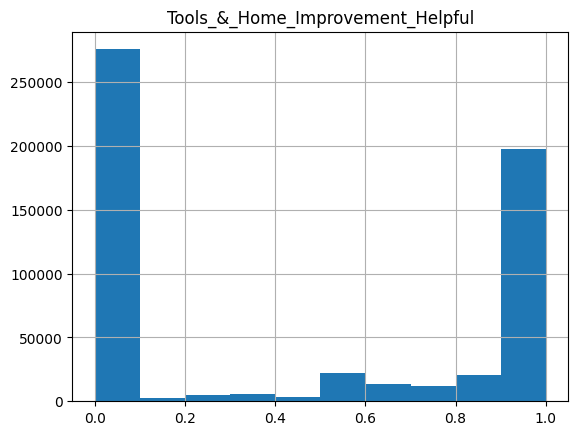

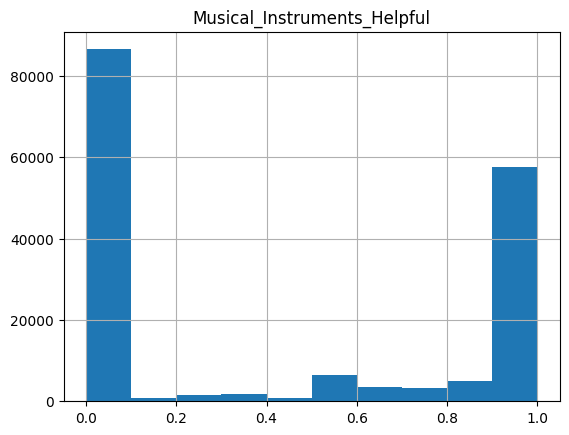

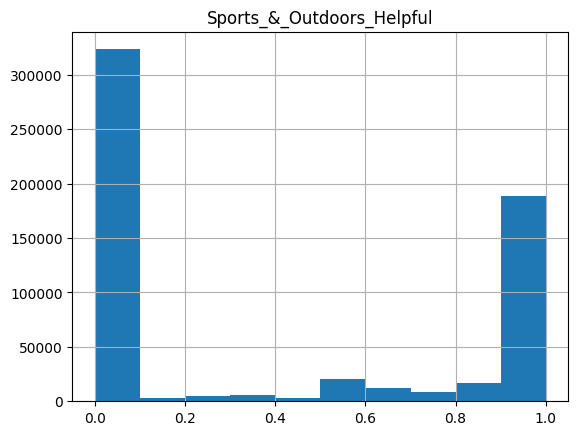

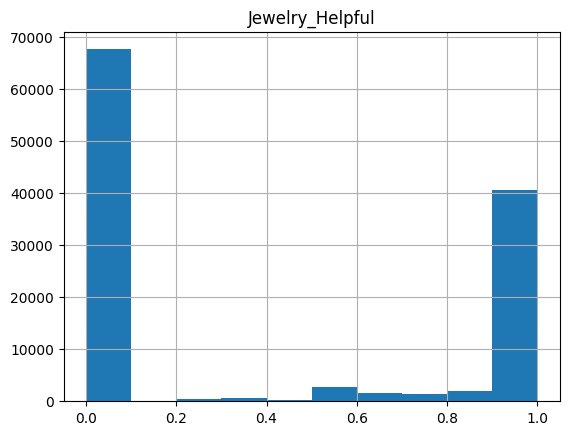

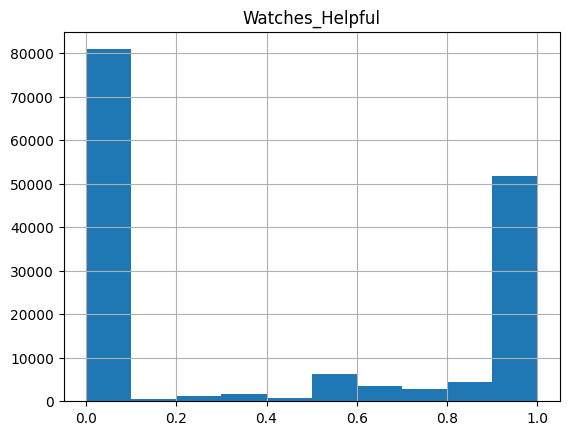

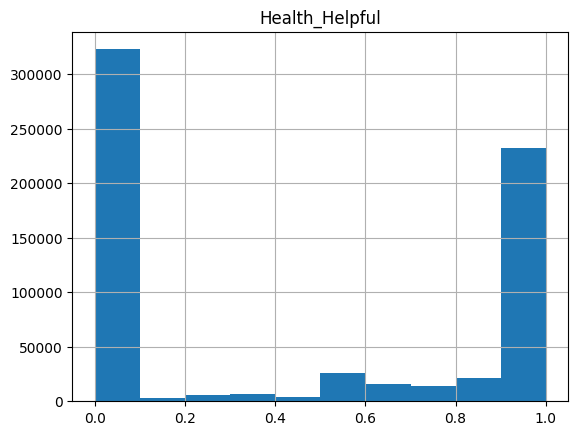

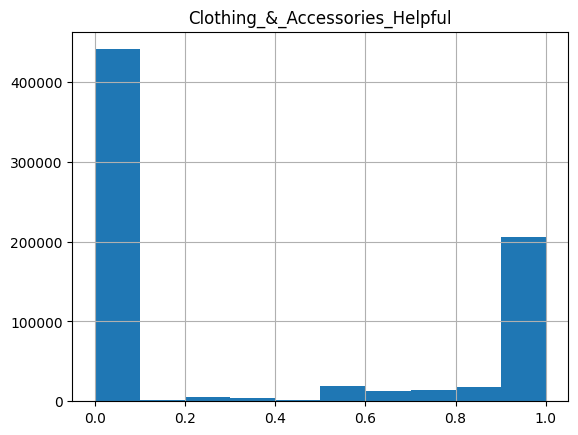

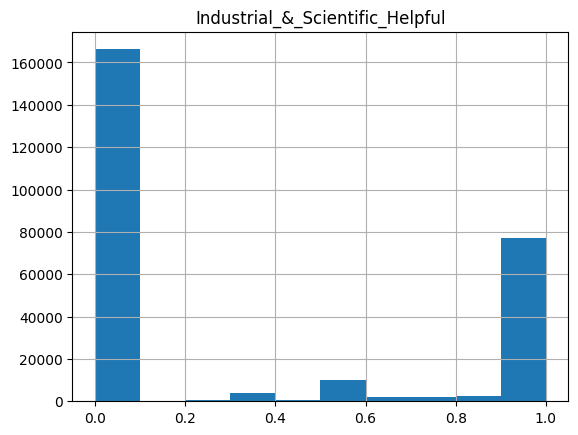

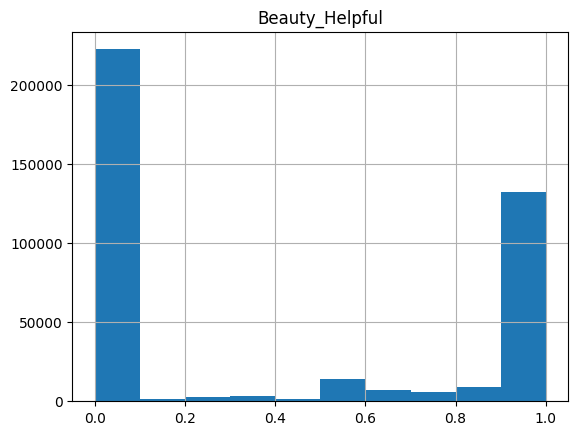

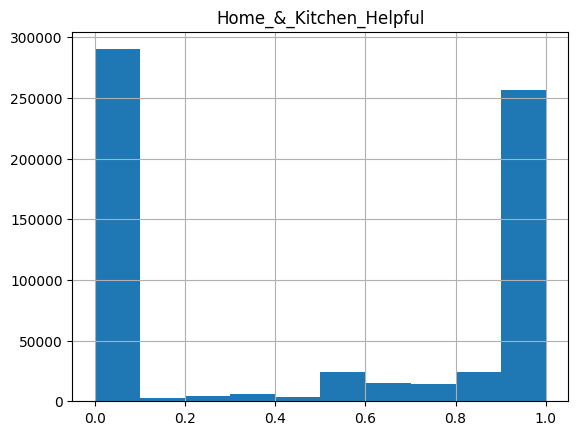

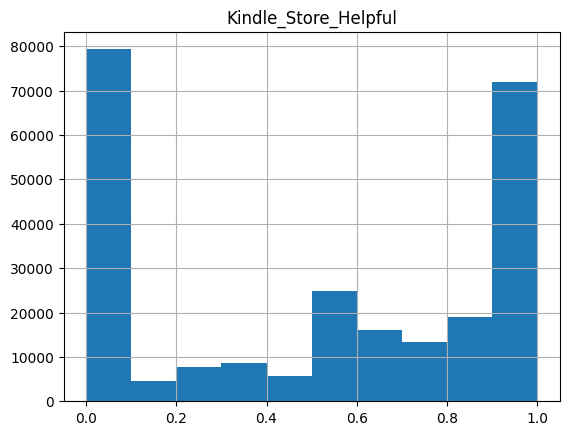

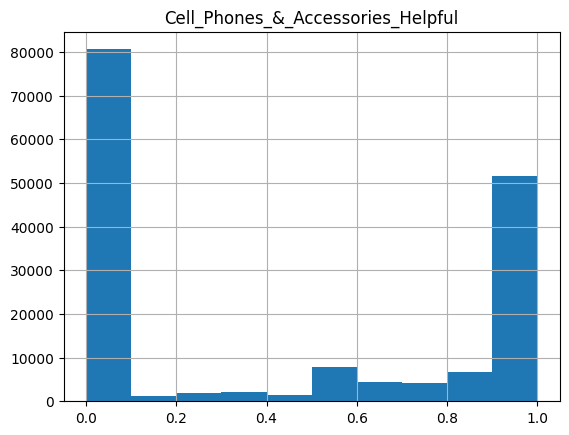

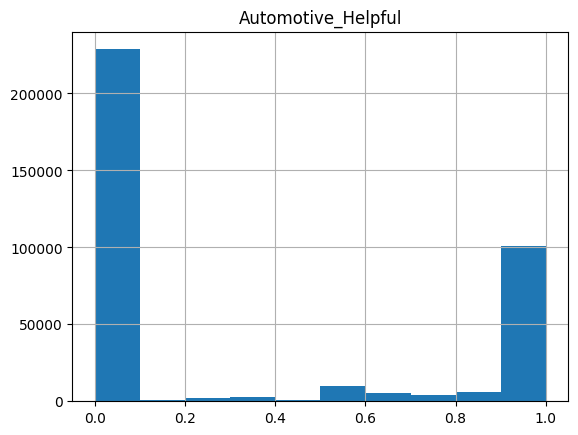

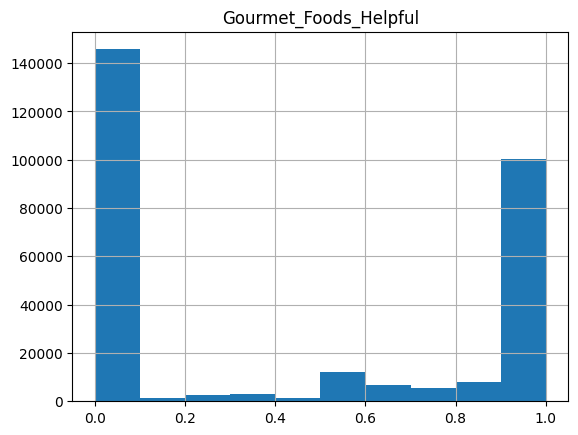

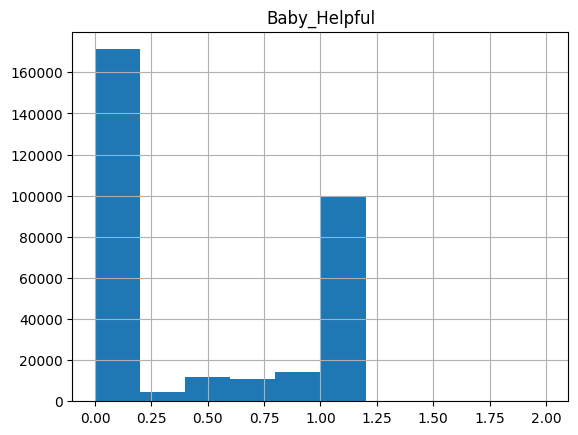

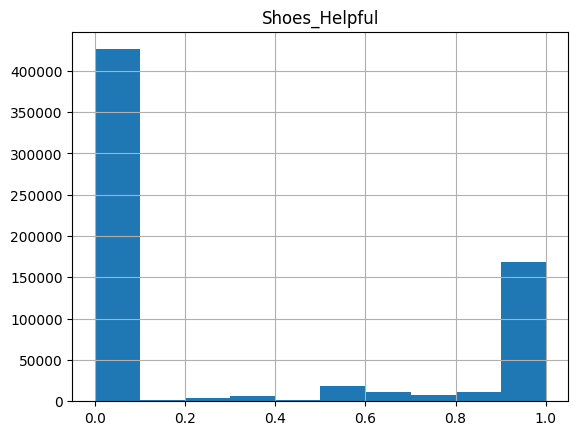

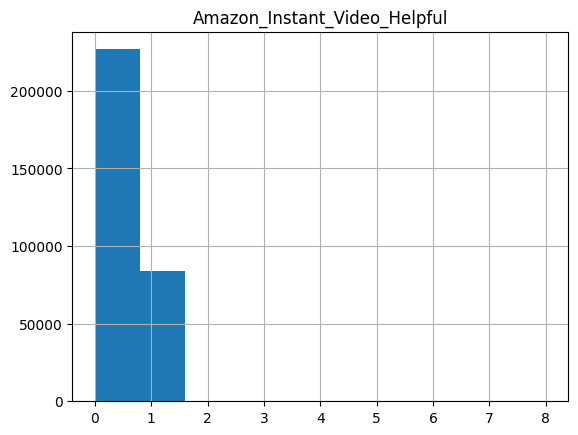

In [14]:
# Get helpfulness metric histograms by category
for category in category_counts:
    curs.execute('select helpfulness from reviews inner join products on products.id = reviews.product_id where products.category=%s',[category['category']])
    cat_helpful = curs.fetchall()            
    cat_helpful_df = pd.DataFrame(cat_helpful)
    cat_helpful_df.columns = [f'{category["category"]}_Helpful']
    cat_helpful_df.hist()

In [15]:
# Get highy helpful reviews with low ratings
curs.execute('select * from products inner join reviews on reviews.product_id=products.id inner join processed_review on processed_review.review_id = reviews.id where reviews.processed = 1 and reviews.helpfulness > 0.5 and reviews.rating < 2.0 limit 10')
kp = curs.fetchall()
kp

[{'id': 5,
  'title': "Zondervan Bible Study Library: Leader's Edition 5.0 [CD] (CD-ROM)",
  'processed': 1,
  'category': 'Software',
  'product_id': '0310230691',
  'helpfulness': 0.535714,
  'rating': 1.0,
  'summary': "Don't have the feature I wanted... I like the NIV translation and I have been jotting down many study notes besides the relevant verses in a hardcopy NIV bible. I thought that the computer age must have created something better than pen and paper to jot notes and I have been looking for software programs that allow me to take notes and attach them to verses in the bible. What attracted me to this software of course the NIV translation but more importantly, their mentioning of the ability to take notes. I t",
  'review_id': '593645',
  'metric_type': 'key_phrases',
  'metric': b'{"phrases": [{"phrase": "hardcopy niv", "score": 0.5383475586932492, "sentence": "1"}]}'},
 {'id': 47,
  'title': 'LightWedge Reading Light',
  'processed': 1,
  'category': 'Tools_&_Home_Impr

In [16]:
# Get topics for not books with a minimum of 5 topics
curs.execute('select * from agg_product_review inner join products on products.id=agg_product_review.product_id where products.category!="Books" limit 10')
topics = curs.fetchall()
for t in topics:
    t['metric'] = json.loads(t['metric'])
most_topics = [t for t in topics if len(t['metric']) > 1 and len(t['metric']) < 10]
most_topics

[{'id': '0005114365',
  'product_id': '0005114365',
  'metric_type': 'topic_analysis',
  'metric': ['high-tech effects',
   'nice message',
   'cute video',
   'church groups',
   'nice video'],
  'title': "The Stableboy's Christmas [VHS]",
  'processed': 0,
  'category': 'Movies_&_TV'},
 {'id': '0005123909',
  'product_id': '0005123909',
  'metric_type': 'topic_analysis',
  'metric': ['mother-in-law bought',
   'whole way',
   'older, dated',
   'old granddaughter',
   'holds attention',
   'other day',
   'way through...Caution..the songs stick',
   'granddaughter LOVES',
   'old loves'],
  'title': 'Silly Songs: 18 Wholesome Fun Songs for Kids [VHS]',
  'processed': 0,
  'category': 'Music'},
 {'id': '0138827966',
  'product_id': '0138827966',
  'metric_type': 'topic_analysis',
  'metric': ['Demo Video".', 'side TV [VH', 'Side TV'],
  'title': 'Side by Side TV [VHS]',
  'processed': 0,
  'category': 'Movies_&_TV'},
 {'id': '0310248396',
  'product_id': '0310248396',
  'metric_type':